📊 CHARGEMENT DU DATASET
Total événements: 1500
Anomalies: 225 (15.00%)
Request count ratio: 156.4x
✅ Dataset de bonne qualité!

🔧 PRÉPARATION DES DONNÉES
Features utilisées: 24
   1. src_ip_hash
   2. kind_encoded
   3. hour_of_day
   4. day_of_week
   5. is_weekend
   6. is_night
   7. is_business_hours
   8. http_status_code
   9. is_error_code
  10. url_length
  ... et 14 autres

Training set: 1200 événements
  Normal: 1020
  Anomalies: 180

Test set: 300 événements
  Normal: 255
  Anomalies: 45

🧠 ENTRAÎNEMENT ISOLATION FOREST
Contamination: 0.150
n_estimators: 300
max_samples: auto

🔄 Entraînement en cours...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.1s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


✅ Modèle entraîné!

🔮 PRÉDICTIONS
Prédictions générées: 300
Scores normalisés: min=0.000, max=1.000

📊 MATRICE DE CONFUSION
   True Negatives:   235 (normaux correctement détectés)
   False Positives:   20 (normaux classés comme anomalies)
   False Negatives:    7 (anomalies manquées)
   True Positives:    38 (anomalies correctement détectées)

📈 MÉTRIQUES
   Recall:    84.44%    (détection des anomalies)
   Precision: 65.52%    (justesse des alertes)
   F1-Score:  73.79%
   AUC:       0.948

🎯 ÉVALUATION FINALE
✅ EXCELLENT! Recall >80% - Le modèle détecte la majorité des anomalies

📊 Génération des visualisations...


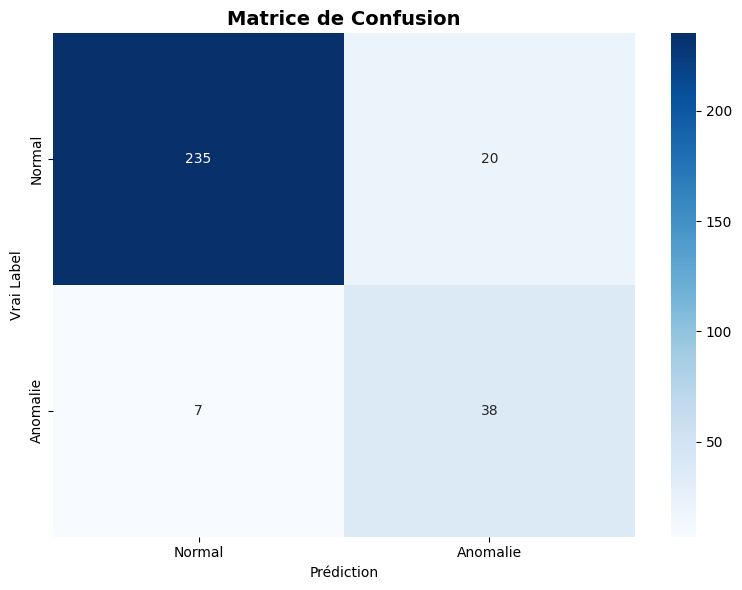

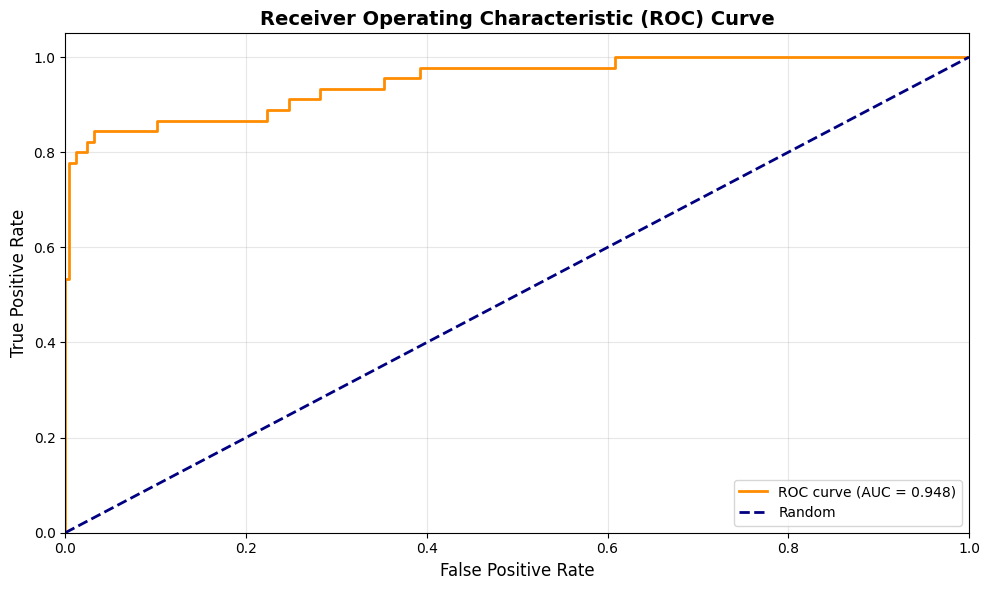

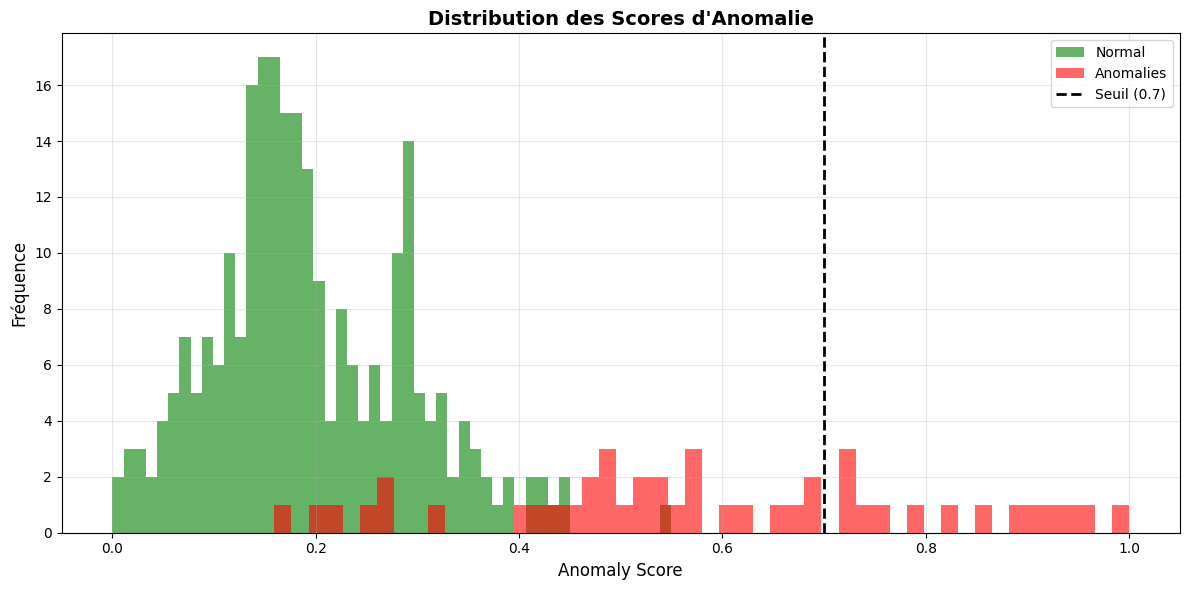

Normal - Moyenne: 0.194, Std: 0.096
Anomalies - Moyenne: 0.586, Std: 0.216

💾 SAUVEGARDE DU MODÈLE
✅ Fichiers sauvegardés:
   - anomaly_model.pkl
   - anomaly_scaler.pkl
   - model_info.json

🎯 RÉSUMÉ FINAL
Dataset: 1500 événements (15.00% anomalies)
Features: 24
Training: 1200 événements
Test: 300 événements

📈 Performances:
   Recall:    84.44%
   Precision: 65.52%
   F1-Score:  73.79%
   AUC:       0.948
   Qualité:   EXCELLENT

🚀 Le modèle est prêt pour le déploiement!


In [1]:
# ============================================================================
# ENTRAÎNEMENT ISOLATION FOREST - VERSION OPTIMALE
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

# Charger le dataset
print("="*80)
print("📊 CHARGEMENT DU DATASET")
print("="*80)

df = pd.read_csv('dataset.csv')
print(f"Total événements: {len(df)}")
print(f"Anomalies: {df['label'].sum()} ({df['label'].mean():.2%})")

# Vérifier la qualité
anomalies = df[df['label'] == 1]
normal = df[df['label'] == 0]
ratio = anomalies['request_count_1min'].mean() / (normal['request_count_1min'].mean() + 0.01)
print(f"Request count ratio: {ratio:.1f}x")

if ratio < 10:
    print("❌ ERREUR: Dataset de mauvaise qualité!")
    print("   Régénérez le dataset!")
else:
    print("✅ Dataset de bonne qualité!")

# Séparer features et labels
print("\n" + "="*80)
print("🔧 PRÉPARATION DES DONNÉES")
print("="*80)

metadata_cols = ['event_id', 'src_ip', 'kind', 'timestamp', 'label']
feature_cols = [col for col in df.columns if col not in metadata_cols]

print(f"Features utilisées: {len(feature_cols)}")
for i, col in enumerate(feature_cols[:10], 1):
    print(f"  {i:2d}. {col}")
if len(feature_cols) > 10:
    print(f"  ... et {len(feature_cols)-10} autres")

X = df[feature_cols].values
y = df['label'].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {len(X_train)} événements")
print(f"  Normal: {(y_train == 0).sum()}")
print(f"  Anomalies: {(y_train == 1).sum()}")
print(f"\nTest set: {len(X_test)} événements")
print(f"  Normal: {(y_test == 0).sum()}")
print(f"  Anomalies: {(y_test == 1).sum()}")

# ============================================================================
# ENTRAÎNEMENT
# ============================================================================
print("\n" + "="*80)
print("🧠 ENTRAÎNEMENT ISOLATION FOREST")
print("="*80)

contamination = y_train.mean()
print(f"Contamination: {contamination:.3f}")
print(f"n_estimators: 300")
print(f"max_samples: auto")

model = IsolationForest(
    n_estimators=300,
    max_samples='auto',
    contamination=contamination,
    max_features=1.0,
    bootstrap=False,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n🔄 Entraînement en cours...")
model.fit(X_train)
print("✅ Modèle entraîné!")

# ============================================================================
# PRÉDICTIONS
# ============================================================================
print("\n" + "="*80)
print("🔮 PRÉDICTIONS")
print("="*80)

# Prédire
y_pred = model.predict(X_test)
anomaly_scores = -model.decision_function(X_test)

# Normaliser les scores
scaler = MinMaxScaler()
anomaly_scores_normalized = scaler.fit_transform(anomaly_scores.reshape(-1, 1)).flatten()

# Convertir prédictions
y_pred_binary = np.where(y_pred == -1, 1, 0)

print(f"Prédictions générées: {len(y_pred_binary)}")
print(f"Scores normalisés: min={anomaly_scores_normalized.min():.3f}, max={anomaly_scores_normalized.max():.3f}")

# ============================================================================
# ÉVALUATION
# ============================================================================
print("\n" + "="*80)
print("📊 MATRICE DE CONFUSION")
print("="*80)

cm = confusion_matrix(y_test, y_pred_binary)

print(f"   True Negatives:   {cm[0,0]:3d} (normaux correctement détectés)")
print(f"   False Positives:  {cm[0,1]:3d} (normaux classés comme anomalies)")
print(f"   False Negatives:  {cm[1,0]:3d} (anomalies manquées)")
print(f"   True Positives:   {cm[1,1]:3d} (anomalies correctement détectées)")

# Calcul des métriques
recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
auc = roc_auc_score(y_test, anomaly_scores_normalized)

print("\n" + "="*80)
print("📈 MÉTRIQUES")
print("="*80)
print(f"   Recall:    {recall:.2%}    (détection des anomalies)")
print(f"   Precision: {precision:.2%}    (justesse des alertes)")
print(f"   F1-Score:  {f1:.2%}")
print(f"   AUC:       {auc:.3f}")

# Évaluation finale
print("\n" + "="*80)
print("🎯 ÉVALUATION FINALE")
print("="*80)

if recall >= 0.80:
    print("✅ EXCELLENT! Recall >80% - Le modèle détecte la majorité des anomalies")
    quality = "EXCELLENT"
elif recall >= 0.70:
    print("✅ BON! Recall 70-80% - Le modèle est performant")
    quality = "BON"
elif recall >= 0.60:
    print("⚠️  ACCEPTABLE! Recall 60-70% - Le modèle peut être amélioré")
    quality = "ACCEPTABLE"
else:
    print("❌ INSUFFISANT! Recall <60% - Le modèle manque trop d'anomalies")
    quality = "INSUFFISANT"

print("="*80)

# ============================================================================
# VISUALISATIONS
# ============================================================================
print("\n📊 Génération des visualisations...")

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomalie'],
            yticklabels=['Normal', 'Anomalie'])
plt.title('Matrice de Confusion', fontsize=14, fontweight='bold')
plt.ylabel('Vrai Label')
plt.xlabel('Prédiction')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, anomaly_scores_normalized)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution des scores
fig, ax = plt.subplots(figsize=(12, 6))
normal_scores = anomaly_scores_normalized[y_test == 0]
anomaly_scores_true = anomaly_scores_normalized[y_test == 1]

ax.hist(normal_scores, bins=50, alpha=0.6, label='Normal', color='green')
ax.hist(anomaly_scores_true, bins=50, alpha=0.6, label='Anomalies', color='red')
ax.axvline(0.7, color='black', linestyle='--', linewidth=2, label='Seuil (0.7)')

ax.set_xlabel('Anomaly Score', fontsize=12)
ax.set_ylabel('Fréquence', fontsize=12)
ax.set_title('Distribution des Scores d\'Anomalie', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Normal - Moyenne: {normal_scores.mean():.3f}, Std: {normal_scores.std():.3f}")
print(f"Anomalies - Moyenne: {anomaly_scores_true.mean():.3f}, Std: {anomaly_scores_true.std():.3f}")

# ============================================================================
# SAUVEGARDE
# ============================================================================
print("\n" + "="*80)
print("💾 SAUVEGARDE DU MODÈLE")
print("="*80)

joblib.dump(model, 'anomaly_model.pkl')
joblib.dump(scaler, 'anomaly_scaler.pkl')

model_info = {
    'feature_names': feature_cols,
    'n_features': len(feature_cols),
    'contamination': float(contamination),
    'recall': float(recall),
    'precision': float(precision),
    'f1_score': float(f1),
    'auc_score': float(auc),
    'quality': quality
}

with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("✅ Fichiers sauvegardés:")
print("   - anomaly_model.pkl")
print("   - anomaly_scaler.pkl")
print("   - model_info.json")

# ============================================================================
# RÉSUMÉ FINAL
# ============================================================================
print("\n" + "="*80)
print("🎯 RÉSUMÉ FINAL")
print("="*80)
print(f"Dataset: {len(df)} événements ({df['label'].mean():.2%} anomalies)")
print(f"Features: {len(feature_cols)}")
print(f"Training: {len(X_train)} événements")
print(f"Test: {len(X_test)} événements")
print(f"\n📈 Performances:")
print(f"   Recall:    {recall:.2%}")
print(f"   Precision: {precision:.2%}")
print(f"   F1-Score:  {f1:.2%}")
print(f"   AUC:       {auc:.3f}")
print(f"   Qualité:   {quality}")
print("="*80)

if recall >= 0.70:
    print("\n🚀 Le modèle est prêt pour le déploiement!")
else:
    print("\n⚠️  Le modèle nécessite des améliorations avant déploiement.")